<h1>Experiments in Gaussian+linear fits to spectra</h1>

In [53]:
# All imports used in this script
from __future__ import print_function

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

#from scipy.interpolate import UnivariateSpline 

%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 10
x_label = '$\lambda$($\mu$)'
y_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'

<h3>Get raw data</h3>

In [54]:
data = np.genfromtxt("data/example_spec_ipac.txt")
wave = data[:,0]
flux = data[:,1]

<h3>Plot entire raw data</h3>

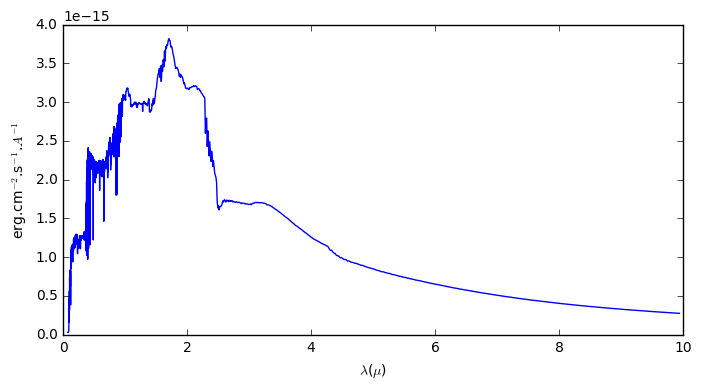

In [55]:
plt.gcf().set_size_inches(8.,4.)
plt.plot(wave, flux)
plt.xlabel(x_label)
plt.ylabel(y_label)

<h3>Extract region of interest </h3>

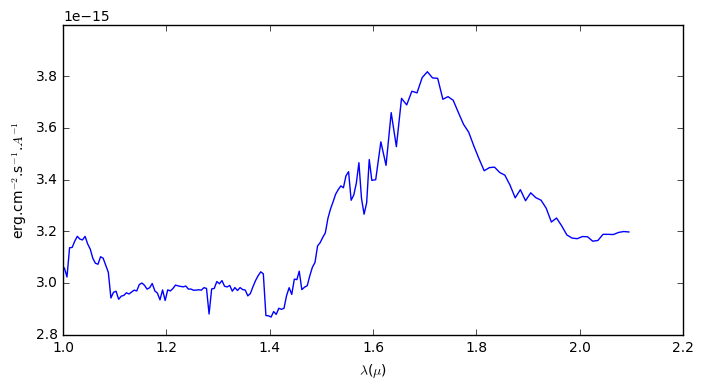

In [56]:
indices = (wave > 1.) & (wave < 2.1)
w = wave[indices]
f = flux[indices]
plt.gcf().set_size_inches(8.,4.)
plt.plot(w, f)
plt.xlabel(x_label)
plt.ylabel(r'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$')

<h3>Fit Gaussian using astropy </h3>

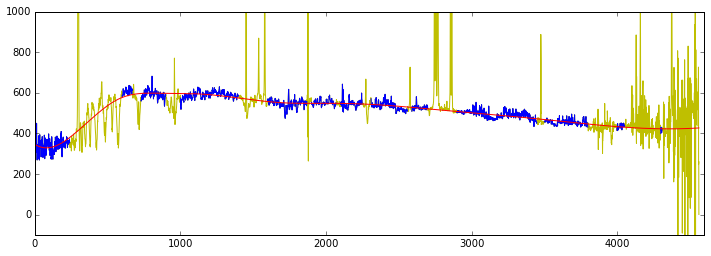

In [22]:
x = np.asarray(range(len(summed_masked)))

w = 1/summed_masked.std() 
weights = np.choose(summed_masked==0.0,(w,0.))

continuum = UnivariateSpline(x, summed, weights, s=0.04*len(weights))(x)

plt.gcf().set_size_inches(12.,4.)
plt.axis([0.,4600.,-100.,1000.])
plt.plot(summed, 'y')
plt.plot(summed_masked, 'b')
plt.plot(continuum, 'r')

<h3>6 - Subtract continuum from cube </h3>

The interpolated continuum spectrum includes the masked regions (that's the whole point of using interpolation in the first place). So we first have to build a masked version of the interpolated continuum, in order to get its flux over the unmasked regions only:

In [23]:
masked_continuum = ma.masked_array(continuum, mask=mask[:,0,0]) # in this example, any spatial pixel should do
continuum_flux = np.sum(masked_continuum)

Before subtracting the continuum from each spatial pixel, it has to be re-normalized to the flux in that spatial pixel. Note that we use the masked cube for the computation of the flux in one pixel, so it can be directly related to the flux in the masked interpolated continuum computed above.

In [24]:
continuum_subtracted_cube = np.zeros(shape=cube.shape) 
# these two loops scan the entire spatial extent of the cube. 
for i in range(cube.shape[1]):
    for j in range(cube.shape[2]):
        pixel_flux = np.sum(masked_cube[:,i,j])
        continuum_subtracted_cube[:,i,j] = cube[:,i,j] - (continuum / continuum_flux * pixel_flux)

<h3>7 - Verify results:</h3>

Apart from noise and fitting errors, the final continuum-subtracted image should contain only the flux from emission line wavelength regions (and perhaps negative flux from absorption lines if they were included in the mask). 

In [25]:
print(np.min(continuum_subtracted_cube))
print(np.max(continuum_subtracted_cube))

-1.90532301488
58.356576154


In [26]:
print(np.min(np.sum(continuum_subtracted_cube, axis=0)))
print(np.max(np.sum(continuum_subtracted_cube, axis=0)))

-51.3599226673
859.107531854


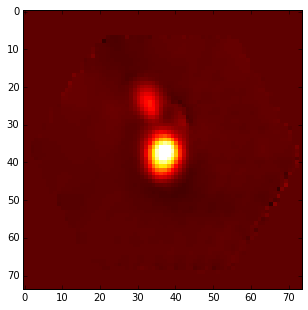

In [27]:
plt.rcParams['figure.figsize'] = 5,5
fig, ax = plt.subplots()
ax.imshow(np.sum(continuum_subtracted_cube, axis=0), vmin=-100, vmax=700, cmap=cm.hot, interpolation='nearest')

We can verify that globally the cube had its continuum removed by plotting its spectrum over the entire spatial extent of the cube:

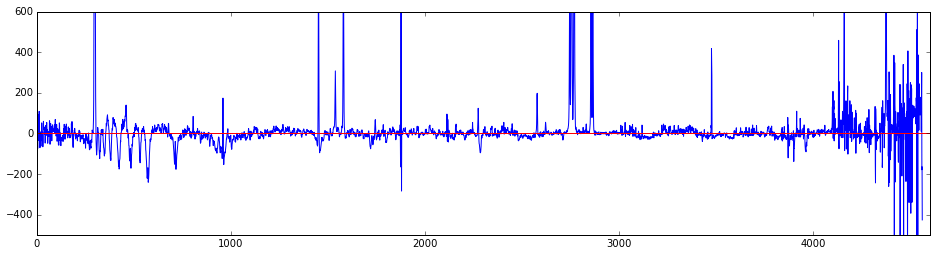

In [28]:
summed_cs = np.sum(continuum_subtracted_cube, axis=2)
summed_cs = np.sum(summed_cs, axis=1)

plt.gcf().set_size_inches(16.,4.)
plt.axis([0.,4600.,-500.,600.])
plt.plot(summed_cs)
plt.plot([0.,4600.], [0., 0.], 'r')